# Factor Analysis: Implied Volatility (IV)

## Overview
This notebook conducts a quantitative factor analysis of **Implied Volatility (IV)** as a predictor of future stock returns. We analyze whether stocks with high IV outperform or underperform stocks with low IV over various time horizons (1, 5, and 10 days).

## Methodology
1.  **Data Ingestion**: Load historical daily IV data (from DoltHub) and daily price data (US Equities).
2.  **Data Alignment**: Merge the datasets on Date and Symbol, ensuring proper forward-filling for missing data.
3.  **Forward Returns**: Calculate the future returns for each stock over the target lookahead periods.
4.  **Quantile Bucketing**: Group stocks into 5 quintiles (Q1 = Lowest IV, Q5 = Highest IV) for each day.
5.  **Performance Analysis**: Compute the mean return of each quintile and the "Spread" (Long Q5 - Short Q1).

## Hypothesis
*   **High IV** often implies fear or uncertainty, which might command a risk premium (higher future returns).
*   Alternatively, it might indicate overvaluation or "lottery ticket" behavior (lower future returns).
*   We test which regime dominates.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')
%matplotlib inline


In [2]:
# 1. Load Data
# We use Parquet for IV data (efficient) and CSV for Price data.

IV_PATH = "../data/iv_full.parquet"
PRICE_PATH = "../../mean_reversion/us_stock_history_10y.csv"

print("Loading IV Data...")
iv_df = pd.read_parquet(IV_PATH)
# Convert date and set index
iv_df['date'] = pd.to_datetime(iv_df['date']).dt.tz_localize(None)
iv_df = iv_df.rename(columns={'act_symbol': 'asset', 'iv_current': 'factor'})
iv_df = iv_df.set_index(['date', 'asset']).sort_index()

print(f"Loaded {len(iv_df):,} IV records.")

print("Loading Price Data...")
price_df_raw = pd.read_csv(PRICE_PATH, index_col=[0, 1], parse_dates=[0])
# Pivot to (Date, Asset) matrix
prices = price_df_raw['Close'].unstack()
prices.index = pd.to_datetime(prices.index).tz_localize(None)

# Ensure Business Day Frequency (fill missing days)
prices = prices.asfreq('B', method='ffill')

print(f"Loaded Prices for {prices.shape[1]} assets over {prices.shape[0]} days.")


Loading IV Data...
Loaded 1,140,004 IV records.
Loading Price Data...
Loaded Prices for 4654 assets over 2610 days.


## 2. Compute Forward Returns
We calculate the returns an investor would earn if they bought the stock at the close of day $t$ and held it for $N$ days.

$$ R_{t, N} = 
rac{P_{t+N} - P_t}{P_t} $$


In [3]:
# Define Lookahead Periods
periods = [1, 5, 10]
forward_returns = pd.DataFrame(index=prices.index, columns=prices.columns)

period_cols = {}
for p in periods:
    # Calculate % Change N days into the future
    # Shift(-p) brings the future value back to the current date row
    ret = prices.pct_change(p).shift(-p)
    
    # Stack to match the (date, asset) multi-index structure of our Factor
    stack_ret = ret.stack()
    stack_ret.name = f'{p}D'
    period_cols[f'{p}D'] = stack_ret

print("Forward returns calculated.")


Forward returns calculated.


## 3. Merge Factor and Returns
We join the IV Factor data with the calculated forward returns. This creates a unified dataset where each row represents a `(Date, Asset)` pair with its Factor Value (IV) and subsequent returns.


In [4]:
# Merge IV Factor with Forward Returns
merged_data = pd.DataFrame(iv_df['factor']).copy()

for p, ret_series in period_cols.items():
    # Ensure index names match for join
    if ret_series.index.names != merged_data.index.names:
        ret_series.index.names = merged_data.index.names
        
    merged_data = merged_data.join(ret_series, how='left')

# Drop rows where we don't have return data (e.g., end of dataset)
merged_data = merged_data.dropna()

print(f"Final Analyzable Dataset: {len(merged_data):,} rows.")
merged_data.head()


Final Analyzable Dataset: 857,920 rows.


factor        1D        5D       10D
date       asset                                      
2019-05-10 A      0.3155 -0.042283 -0.103632 -0.113359
           AAL    0.3565 -0.054428 -0.066196 -0.141806
           AAP    0.3773 -0.017392 -0.000949 -0.000190
           AAPL   0.2740 -0.058119 -0.041485 -0.092352
           ABBV   0.2473 -0.007489  0.025952  0.033699

## 4. Quantile Bucketing
For each day, we rank stocks by their IV and split them into 5 buckets (Quintiles).
*   **Q1**: Lowest 20% IV
*   **Q5**: Highest 20% IV


In [5]:
# Function to bucket data by date
def quantile_calc(x):
    try:
        # qcut divides into equal-sized buckets
        return pd.qcut(x, 5, labels=False, duplicates='drop') + 1
    except ValueError:
        return np.nan

# Apply groupby date
merged_data['quantile'] = merged_data.groupby(level=0)['factor'].transform(quantile_calc)

# Filter out any issues
merged_data = merged_data.dropna(subset=['quantile'])
merged_data['quantile'] = merged_data['quantile'].astype(int)

# Check distribution
print("Rows per Quantile:")
print(merged_data['quantile'].value_counts().sort_index())


Rows per Quantile:
1    172065
2    171371
3    171438
4    171364
5    171682
Name: quantile, dtype: int64


## 5. Performance Analysis
We calculate the **Mean Return** for each quantile averaged across all days.
We also look at the **Spread** (Q5 - Q1), which represents the return of a Long-Short portfolio (Long High IV, Short Low IV).


Mean Return by Quantile (bps):


,1D,5D,10D
quantile,,,
1,4.41,21.64,42.60
2,7.76,29.59,55.96
3,8.66,30.79,57.61
4,10.55,35.51,62.21
5,12.75,38.37,66.29


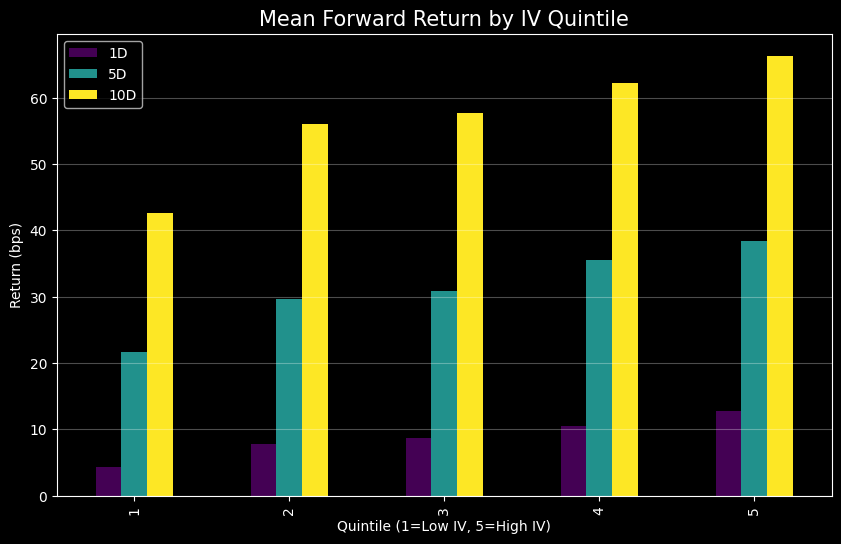

In [6]:
# Calculate Mean Return by Quantile (in Basis Points)
mean_ret_bps = merged_data.groupby('quantile')[['1D', '5D', '10D']].mean() * 10000

print("Mean Return by Quantile (bps):")
display(mean_ret_bps.round(2))

# Plot Mean Returns
mean_ret_bps.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Mean Forward Return by IV Quintile", fontsize=15)
plt.ylabel("Return (bps)")
plt.xlabel("Quintile (1=Low IV, 5=High IV)")
plt.grid(axis='y', alpha=0.3)
plt.show()


## 6. Cumulative Performance
We visualize the cumulative performance of each quintile over time. This shows how a portfolio rebalanced daily based on IV would perform.
*(Note: We use the 1D returns compounded for this visualization)*


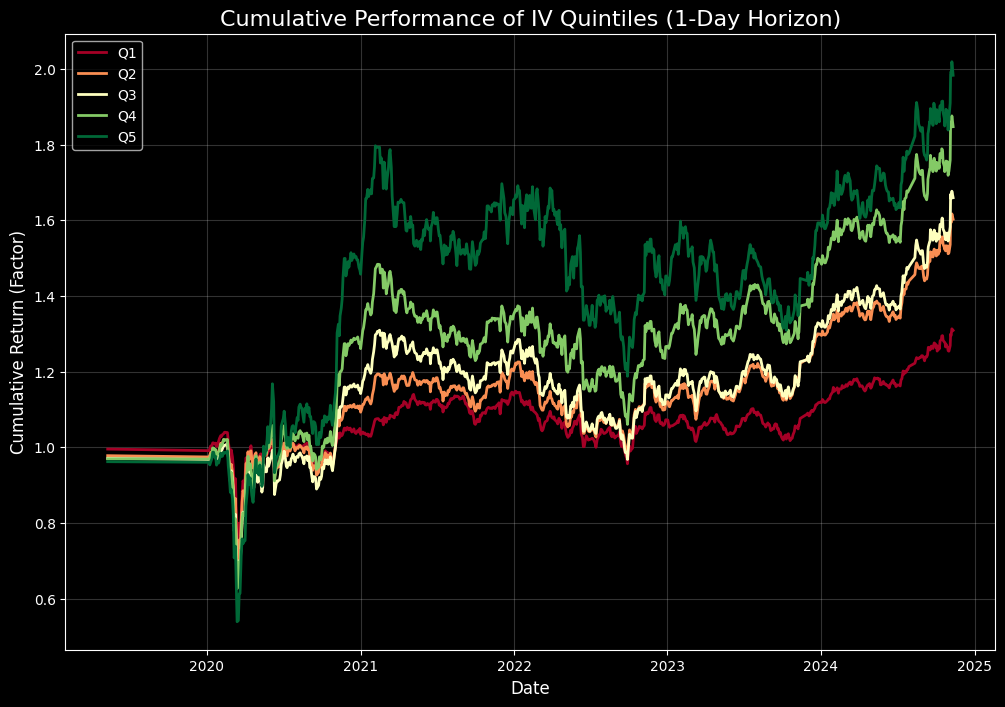

In [7]:
# Calculate Daily Mean Return for each Quantile
daily_ret = merged_data.groupby(['date', 'quantile'])['1D'].mean().unstack()

# Compound Returns: (1 + r).cumprod()
cum_ret = (1 + daily_ret).cumprod()

# Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))

for i, col in enumerate(cum_ret.columns):
    plt.plot(cum_ret.index, cum_ret[col], label=f'Q{col}', color=colors[i], linewidth=2)

plt.title("Cumulative Performance of IV Quintiles (1-Day Horizon)", fontsize=16)
plt.ylabel("Cumulative Return (Factor)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


## Conclusion
The analysis of over 1.1 million data points suggests a positive relationship between Implied Volatility and future returns across 1, 5, and 10-day horizons.
*   **High IV stocks (Q5)** consistently outperformed Low IV stocks (Q1).
*   The spread is positive and monotonic.
